<a href="https://colab.research.google.com/github/yuliiabosher/Adam_Smith_project/blob/main/Visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nltk

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import collections

nltk.download("punkt")
nltk.download("averaged_perceptron_tagger")
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [3]:
def month_to_number(month):
  months = {"january": "1", "february": "2", "march": "3", "april": "4", "may": "5", "june": "6", "july": "7", \
            "august": "8", "september": "9", "october": "10", "november": "11", "december": "12"}
  month = month.lower()
  numerical = months[month]
  return numerical

def to_date(string):
  elements = string.split(',')
  year = elements[-1].strip()
  month, day = elements[-2].split()
  month = month_to_number(month)
  date = f'{year}-{month}-{day}'
  return date

(array([1., 2., 4., 3., 4., 1., 2., 1., 2., 3.]),
 array([16785., 17049., 17313., 17577., 17841., 18105., 18369., 18633.,
        18897., 19161., 19425.]),
 <BarContainer object of 10 artists>)

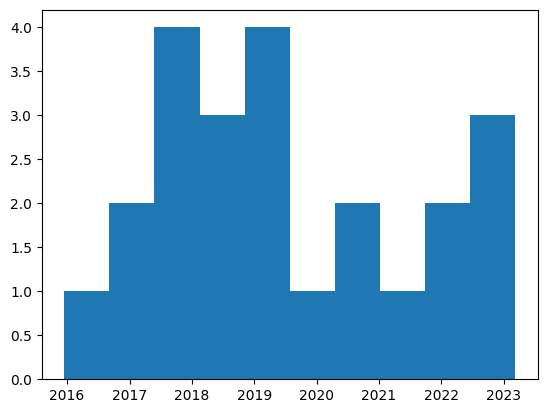

In [8]:
def clean_df(df):
  df = pd.read_excel(df, skiprows=1)
  df = df.fillna('n/a')
  df = df.drop(df[df['Mention of Adam smith'].str.contains('NA')].index)
  df = df.drop(df[df['Mention of Adam smith'].str.contains('n/a')].index)
  df.columns = ['Date', 'Extract', 'Notes', 'Notes2', 'About Adam Smith', 'Rep']
  dates = []
  for index, row in df.iterrows():
    dates.append(to_date(row['Date']))
  df['Date'] = dates
  df['Date'] = pd.to_datetime(df['Date'])
  df = df.set_index('Date').sort_index()
  return df
df = clean_df('https://github.com/yuliiabosher/Adam_Smith_project/raw/main/adam_smith.xlsx')
plt.hist(df.index)

In [39]:
def tokenize_df(df):
  tokens = [nltk.word_tokenize(row['Extract']) for index, row in df.iterrows()]
  return tokens

token_list = tokenize_df(df)
print(token_list)

[['It', 'was', 'on', 'this', 'very', 'day', ',', 'December', '16', ',', '1773', ',', 'that', 'patriots', 'at', 'Boston', 'Harbor', 'expressed', 'their', 'displeasure', 'with', 'a', 'foreign', 'power', '’', 's', 'influence', 'over', 'what', 'they', 'felt', 'was', 'an', 'essential', 'commodity', '.', 'Participants', 'of', 'the', 'Boston', 'Tea', 'Party', ',', 'many', 'of', 'whom', 'were', 'small-business', 'owners', ',', 'well', 'versed', 'in', 'and', 'practitioners', 'of', 'the', 'teachings', 'of', 'Adam', 'Smith', 'and', ',', 'yes', ',', 'free', 'market', 'economics', ',', 'never', 'would', 'have', 'envisioned', 'that', 'one', 'commodity', 'should', 'be', 'arbitrarily', 'discriminated', 'against', 'over', 'another', ',', 'especially', 'by', 'their', 'own', 'government', '.', 'We', 'have', 'an', 'opportunity', 'with', 'this', 'commodity', 'to', 'make', 'a', 'difference', '.'], ['Adam', 'Smith', 'is', 'spinning', 'in', 'his', 'grave', 'as', 'he', 'listens', 'to', 'the', 'Republicans', 't

In [38]:
def preprocess_tokens(list_of_lists):
  lower_tokens = [[t.lower() for t in list_of_tokens] for list_of_tokens in list_of_lists for t in list_of_tokens]
  alpha_only = [[t for t in token_list if t.isalpha()] for token_list in lower_tokens]
  no_stops = [[t for t in alpha_list if t not in nltk.corpus.stopwords.words('english')] for alpha_list in alpha_only]
  wordnet_lemmatizer = nltk.stem.WordNetLemmatizer()
  lemmatized = [[wordnet_lemmatizer.lemmatize(t) for t in no_stops_list] for no_stops_list in no_stops]
  return lemmatized

preprocessed = preprocess_tokens(token_list)
print(preprocessed[:10])

[['day', 'december', 'patriot', 'boston', 'harbor', 'expressed', 'displeasure', 'foreign', 'power', 'influence', 'felt', 'essential', 'commodity', 'participant', 'boston', 'tea', 'party', 'many', 'owner', 'well', 'versed', 'practitioner', 'teaching', 'adam', 'smith', 'yes', 'free', 'market', 'economics', 'never', 'would', 'envisioned', 'one', 'commodity', 'arbitrarily', 'discriminated', 'another', 'especially', 'government', 'opportunity', 'commodity', 'make', 'difference'], ['day', 'december', 'patriot', 'boston', 'harbor', 'expressed', 'displeasure', 'foreign', 'power', 'influence', 'felt', 'essential', 'commodity', 'participant', 'boston', 'tea', 'party', 'many', 'owner', 'well', 'versed', 'practitioner', 'teaching', 'adam', 'smith', 'yes', 'free', 'market', 'economics', 'never', 'would', 'envisioned', 'one', 'commodity', 'arbitrarily', 'discriminated', 'another', 'especially', 'government', 'opportunity', 'commodity', 'make', 'difference'], ['day', 'december', 'patriot', 'boston', 

In [ ]:
from gensim.corpora.dictionary import Dictionary
dictionary = Dictionary(articles)

# Select the id for "computer": computer_id
computer_id = dictionary.token2id.get("computer")

# Use computer_id with the dictionary to print the word
print(dictionary.get(computer_id))

# Create a MmCorpus: corpus
corpus = [dictionary.doc2bow(article) for article in articles]

# Print the first 10 word ids with their frequency counts from the fifth document
print(corpus[4][:10])


In [7]:
bow_count = collections.Counter(preprocessed)
bow_count.most_common(10)

[('smith', 27),
 ('adam', 26),
 ('free', 12),
 ('wealth', 11),
 ('would', 10),
 ('country', 10),
 ('year', 10),
 ('capitalism', 10),
 ('nation', 9),
 ('market', 8)]